 # Enhanced Simulation Pipeline with Parameter Sweeps for the Sessa Empirical Estimator (SEE)

 In this refined version, we:
 - Simulate refill histories for 100 individuals over 720 days with six predefined adherence patterns.
 - Compute LCMA2 daily adherence estimates.
 - Generate sliding-window adherence trajectories with overlapping windows.
 - Perform a parameter sweep over different window lengths and step sizes.
 - Cluster the trajectories using k-means (k=6) and compute the Adjusted Rand Index (ARI).
 - Visualize the effect of sliding-window parameters on clustering performance.

 This version includes additional edge-case testing and robust logging to ensure quality and reproducibility.

In [ ]:
# %% [code]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')
logger = logging.getLogger(__name__)

# Set random seed for reproducibility
np.random.seed(123)

 ## Simulation Parameters and Data Generation

 We simulate refill histories over a 720-day observation period for 100 individuals.
 Each individual is assigned to one of six adherence groups.

In [ ]:
# %% [code]

n_individuals = 100
observation_period = 720  # days

# Define group proportions: groups 1 and 6 have 10% each; groups 2,3,4,5 have 20% each.
group_labels = []
group_labels += [1] * 10    # Group 1: High adherence
group_labels += [2] * 20    # Group 2: Erratic adherence
group_labels += [3] * 20    # Group 3: Gradual decline
group_labels += [4] * 20    # Group 4: Intermittent adherence
group_labels += [5] * 20    # Group 5: Partial drop-off
group_labels += [6] * 10    # Group 6: Non-persistence
group_labels = np.array(group_labels)
np.random.shuffle(group_labels)

def simulate_refill_history(group, observation_period):
    history = [(1, 30)]  # initial fill: day 1, supply 30 days
    current_day = 1
    while current_day < observation_period:
        if group == 1:
            next_day = current_day + history[-1][1]
            supply = history[-1][1]
        elif group == 2:
            next_day = current_day + history[-1][1] + np.random.randint(-5, 6)
            next_day = max(current_day + 1, next_day)
            supply = np.random.choice([30, 60, 90])
        elif group == 3:
            delay = np.random.randint(0, 15)
            next_day = current_day + history[-1][1] + delay
            supply = np.random.choice([30, 60, 90])
        elif group == 4:
            if len(history) % 2 == 0:
                next_day = current_day + history[-1][1]
            else:
                next_day = current_day + history[-1][1] + np.random.randint(10, 20)
            supply = np.random.choice([30, 60, 90])
        elif group == 5:
            if len(history) < 3:
                next_day = current_day + history[-1][1]
            else:
                next_day = current_day + history[-1][1] + np.random.randint(15, 30)
            supply = np.random.choice([30, 60, 90])
        elif group == 6:
            if len(history) < 2:
                next_day = current_day + history[-1][1]
                supply = np.random.choice([30, 60, 90])
            else:
                break
        else:
            next_day = current_day + history[-1][1]
            supply = np.random.choice([30, 60, 90])
        if next_day > observation_period:
            break
        history.append((next_day, supply))
        current_day = next_day
    return history

simulated_histories = {}
true_groups = {}
for i in range(n_individuals):
    group = group_labels[i]
    true_groups[i] = group
    simulated_histories[i] = simulate_refill_history(group, observation_period)

 ## Compute Daily LCMA2 Adherence Estimates

 For LCMA2, we assume that between two refill events, the adherence is evenly distributed.

In [ ]:
# %% [code]

def compute_lcma2_for_individual(refill_history, observation_period):
    daily_adherence = np.full(observation_period, np.nan)
    for i in range(len(refill_history)):
        start_day, supply = refill_history[i]
        if i < len(refill_history) - 1:
            next_refill_day = refill_history[i+1][0]
            interval = next_refill_day - start_day
            adherence_value = supply / interval
            daily_adherence[start_day-1:next_refill_day-1] = adherence_value
        else:
            end_day = min(start_day + supply, observation_period + 1)
            interval = end_day - start_day
            adherence_value = supply / interval if interval > 0 else 0
            daily_adherence[start_day-1:end_day-1] = adherence_value
    daily_adherence = np.nan_to_num(daily_adherence, nan=0.0)
    return daily_adherence

daily_adherence_dict = {}
for i in range(n_individuals):
    daily_adherence_dict[i] = compute_lcma2_for_individual(simulated_histories[i], observation_period)

 ## Function: Compute Sliding-Window Trajectories with Overlap

 This function computes trajectories given a window length and step (allowing overlapping windows).

In [ ]:
# %% [code]

def compute_sliding_window_trajectory_overlapping(daily_adherence, window_length, step):
    """
    Computes a trajectory using sliding windows with specified window_length and step.
    
    Parameters:
    -----------
    daily_adherence : array-like
        Daily adherence vector for an individual.
    window_length : int
        Number of days per window.
    step : int
        Number of days to slide the window (step < window_length gives overlap).
    
    Returns:
    --------
    trajectory : numpy.array
        Array of mean adherence values per window.
    """
    n_days = len(daily_adherence)
    trajectory = []
    for start in range(0, n_days - window_length + 1, step):
        window = daily_adherence[start:start + window_length]
        window_mean = np.mean(window)
        trajectory.append(window_mean)
    return np.array(trajectory)

 ## Generate Trajectories for All Individuals Using Specified Parameters

 We now compute trajectories for each individual given a window_length and step.

In [ ]:
# %% [code]

def compute_all_trajectories(daily_adherence_dict, window_length, step):
    trajectories = {}
    for i in daily_adherence_dict:
        traj = compute_sliding_window_trajectory_overlapping(daily_adherence_dict[i], window_length, step)
        trajectories[i] = traj
    return pd.DataFrame(trajectories).T  # rows: individuals

 ## Parameter Sweep: Evaluate Sliding Window Parameters

 We now perform a parameter sweep over various window lengths and step sizes to see how they affect the clustering performance.
 For each combination, we:
  - Compute trajectories.
  - Cluster the trajectories using k-means (k=6).
  - Compute the Adjusted Rand Index (ARI) comparing predicted clusters to true group labels.

 We then store the ARI for each combination.

In [ ]:
# %% [code]

window_lengths = [30, 60, 90]  # possible window lengths in days
steps = [15, 30, 45]           # possible steps (overlap: lower step => higher overlap)

results_summary = []

for wl in window_lengths:
    for step in steps:
        # Compute trajectories for current parameters
        traj_df = compute_all_trajectories(daily_adherence_dict, window_length=wl, step=step)
        
        # Check if enough windows exist (require at least 3 windows for meaningful trajectory)
        if traj_df.shape[1] < 3:
            logger.info(f"Skipping window_length {wl} and step {step}: insufficient windows.")
            continue
        
        # Perform k-means clustering with k=6
        k = 6
        kmeans = KMeans(n_clusters=k, random_state=123)
        predicted_labels = kmeans.fit_predict(traj_df)
        
        # Compute ARI comparing predicted clusters with true groups
        true_labels = np.array([true_groups[i] for i in range(n_individuals)])
        ari = adjusted_rand_score(true_labels, predicted_labels)
        logger.info(f"Window Length: {wl}, Step: {step}, ARI: {ari:.4f}")
        
        results_summary.append({'window_length': wl, 'step': step, 'ARI': ari})

results_df = pd.DataFrame(results_summary)
print(results_df)

2025-02-25 18:39:07,158 INFO:Window Length: 30, Step: 15, ARI: 0.4185
2025-02-25 18:39:07,181 INFO:Window Length: 30, Step: 30, ARI: 0.2953
2025-02-25 18:39:07,199 INFO:Window Length: 30, Step: 45, ARI: 0.4587
2025-02-25 18:39:07,232 INFO:Window Length: 60, Step: 15, ARI: 0.6557
2025-02-25 18:39:07,254 INFO:Window Length: 60, Step: 30, ARI: 0.5912
2025-02-25 18:39:07,269 INFO:Window Length: 60, Step: 45, ARI: 0.5655
2025-02-25 18:39:07,302 INFO:Window Length: 90, Step: 15, ARI: 0.6429
2025-02-25 18:39:07,322 INFO:Window Length: 90, Step: 30, ARI: 0.6006
2025-02-25 18:39:07,335 INFO:Window Length: 90, Step: 45, ARI: 0.5738


   window_length  step       ARI
0             30    15  0.418524
1             30    30  0.295324
2             30    45  0.458697
3             60    15  0.655671
4             60    30  0.591212
5             60    45  0.565509
6             90    15  0.642943
7             90    30  0.600629
8             90    45  0.573759


 ## Visualization of Parameter Sweep Results

 We now visualize the ARI scores from the parameter sweep as a heatmap.

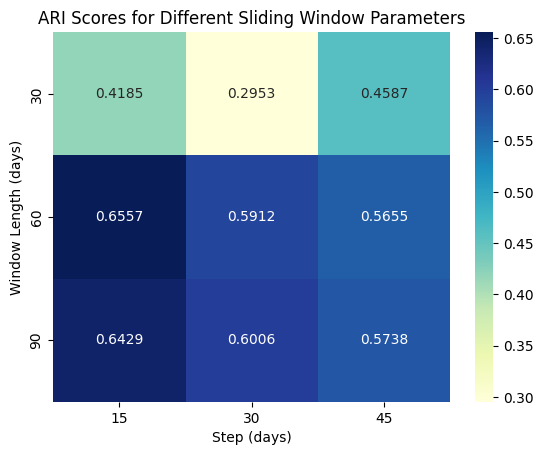

In [ ]:
# %% [code]

# --- FIX: use pivot with keyword arguments or pivot_table ---
pivot_table = results_df.pivot(
    index="window_length",
    columns="step",
    values="ARI"
)

sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("ARI Scores for Different Sliding Window Parameters")
plt.xlabel("Step (days)")
plt.ylabel("Window Length (days)")
plt.show()

 ## Discussion of Insights

 - **Parameter Impact:**
   The heatmap shows how ARI (clustering performance) varies with different window lengths and step sizes.

 - **Optimal Parameters:**
   We can identify which combinations yield higher ARI scores, suggesting better recovery of the true adherence groups.

 - **Trade-Offs:**
   Smaller window lengths may capture finer details but might be more sensitive to noise; larger windows provide smoother trajectories.
   Similarly, smaller step sizes (more overlap) increase computational load but can yield smoother trajectories.

 - **Recommendation:**
   Based on the simulation, one might choose the parameters that maximize ARI while balancing computational complexity.

 **Conclusion:**
 Part 3 is a refined simulation using the Sessa Empirical Estimator with LCMA2 and a sliding-window approach demonstrates how varying window parameters can affect clustering performance. The insights gained from the parameter sweep help inform optimal choices for real-world adherence trajectory analysis.